In [1]:
import os
import logging

logging.disable()
date = '2019-10-05'
data_location = '/user/simon/data/soar/flat_analisis_2019B/'
full_path_data_location = os.path.join(data_location, date)
# "2019-08-06"
# "2019-08-10"
# "2019-08-23"
# "2019-09-04"
# "2019-09-06"
# "2019-09-22"
# "2019-09-23"
# "2019-10-05"
# "2019-10-08"
# "2019-10-20"
# "2019-11-02"
# "2019-11-19"
# "2019-11-29"
# "2019-12-03"
# "2019-12-15"
# "2019-12-18"
# "2019-12-19"
# "2020-01-02"
# "2020-01-19"
# "2020-01-31"


In [2]:
import os
from ccdproc import ImageFileCollection, CCDData, subtract_bias
KEYWORDS = ['slit',
            'grating',
            'cam_targ',
            'grt_targ',
            'filter',
            'filter2',
            'gain',
            'roi',
            'wavmode',
            'exptime',
            'rdnoise',
            'ccdsum']

def get_flat_files_as_pandas_dataframe():
    ifc = ImageFileCollection(location=full_path_data_location, keywords=KEYWORDS, glob_include='*FLAT*')
    df = ifc.summary.to_pandas()
    groups = df.groupby(['slit',
                         'grating',
                         'cam_targ',
                         'grt_targ',
                         'filter',
                         'filter2',
                         'gain',
                         'roi',
                         'wavmode',
                         'exptime',
                         'rdnoise',
                         'ccdsum']).size().reset_index().rename(
        columns={0: 'count'})
    all_groups = []
    for i in groups.index:
        conf_group = df[((df['slit'] == groups.iloc[i]['slit']) &
                         (df['grating'] == groups.iloc[i]['grating']) &
                         (df['cam_targ'] == groups.iloc[i]['cam_targ']) &
                         (df['grt_targ'] == groups.iloc[i]['grt_targ']) &
                         (df['filter'] == groups.iloc[i]['filter']) &
                         (df['filter2'] == groups.iloc[i]['filter2']) &
                         (df['gain'] == groups.iloc[i]['gain']) &
                         (df['roi'] == groups.iloc[i]['roi']) &
                         (df['wavmode'] == groups.iloc[i]['wavmode']) &
                         (df['exptime'] == groups.iloc[i]['exptime']) &
                         (df['rdnoise'] == groups.iloc[i]['rdnoise']) &
                         (df['ccdsum'] == groups.iloc[i]['ccdsum']))]
        if len(conf_group) > 2:
            all_groups.append(conf_group.sort_values(by='file'))
        else:
            print("Group's length: {}".format(len(conf_group)))
            for __File in conf_group.file.values.tolist():
                print("Discarding File: {}".format(__File))
    return all_groups

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def visualize_as_grid(group, date):
    group_name = "Date: {} Wavemode: {} Exptime: {}s".format(date, group.wavmode.unique()[0], group.exptime.unique()[0])
    nrows = int(np.ceil(len(group)/2.))
    ncols = 2
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (16, nrows * 3 ))
   
    fig = plt.figure(figsize = (16, nrows * 3 ))
    fig.suptitle(group_name, fontsize=16)
    gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i, fits_file in enumerate(group.file.tolist()):
        ccd = CCDData.read(os.path.join(full_path_data_location, fits_file), unit='adu')
        z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
        z2 = np.median(ccd.data) + np.std(ccd.data)
        if i%2 == 0:
            y=0
        else:
            y=1
        ax_x = fig.add_subplot(gs[int(np.floor(i/2.)), y])
        ax_x.imshow(ccd.data, clim=(z1, z2), cmap='viridis')
        ax_x.title.set_text(fits_file)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

##  Analisys


In [4]:

groups = get_flat_files_as_pandas_dataframe()

### Visual Inspection

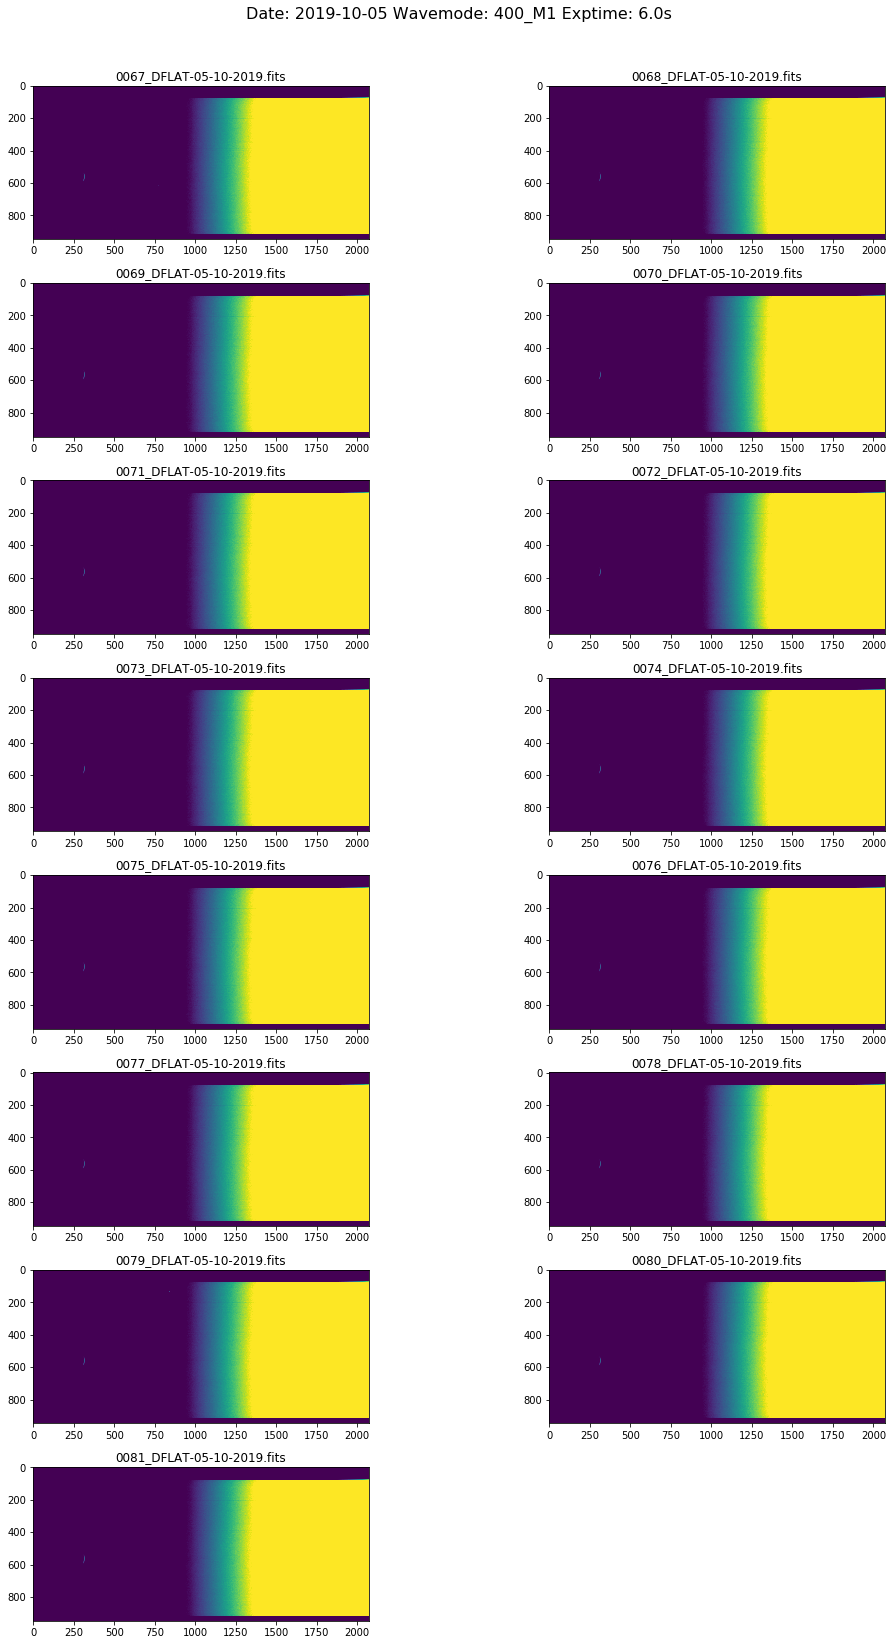

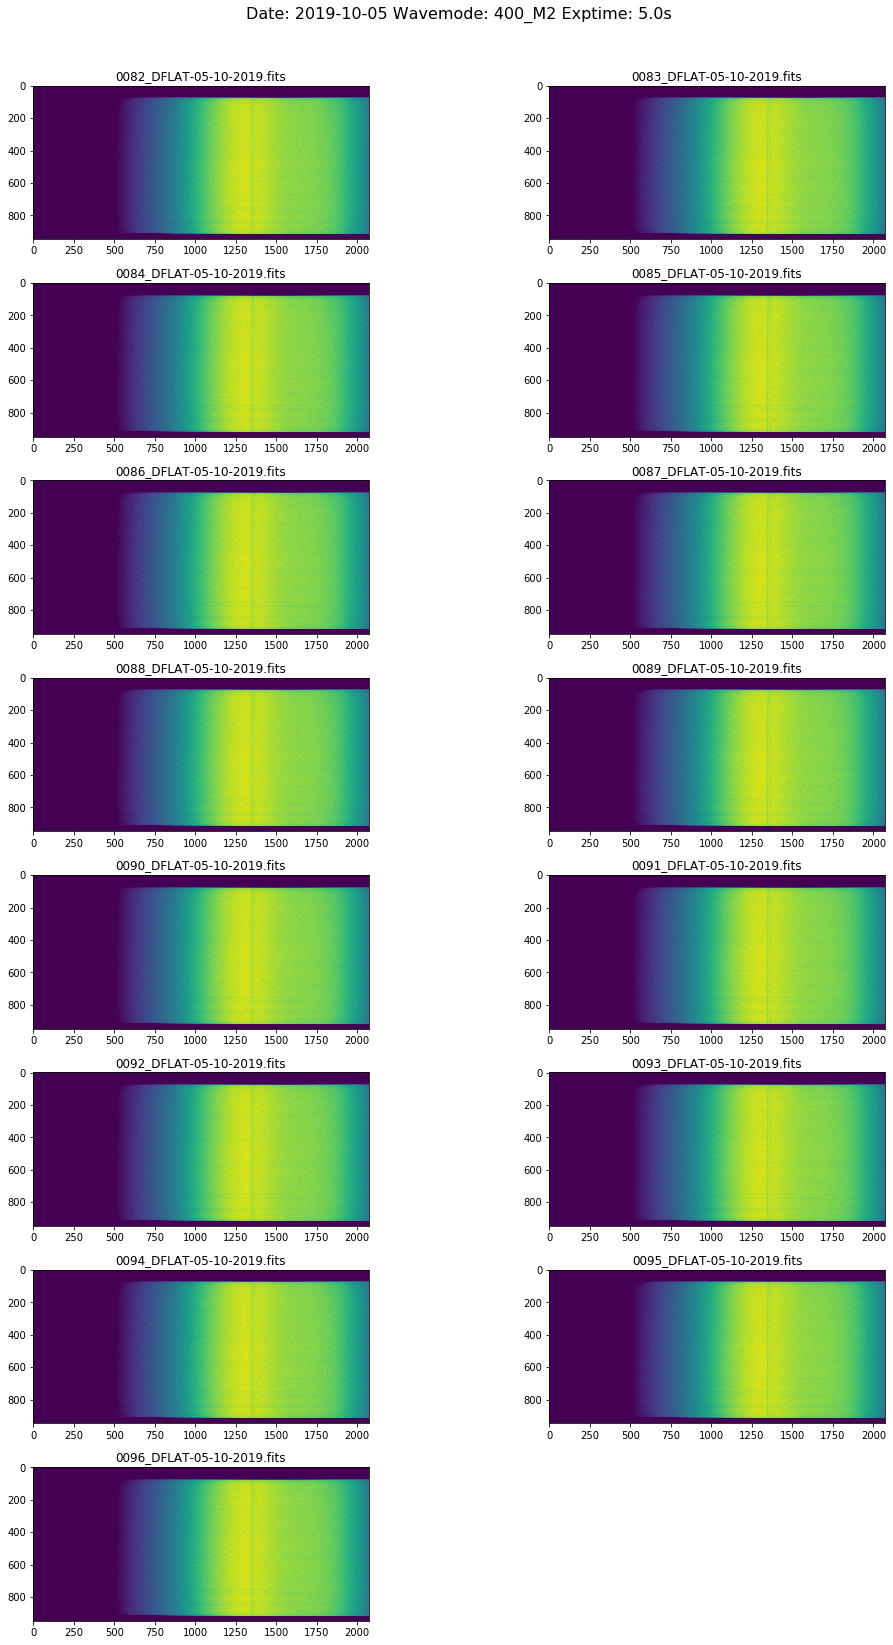

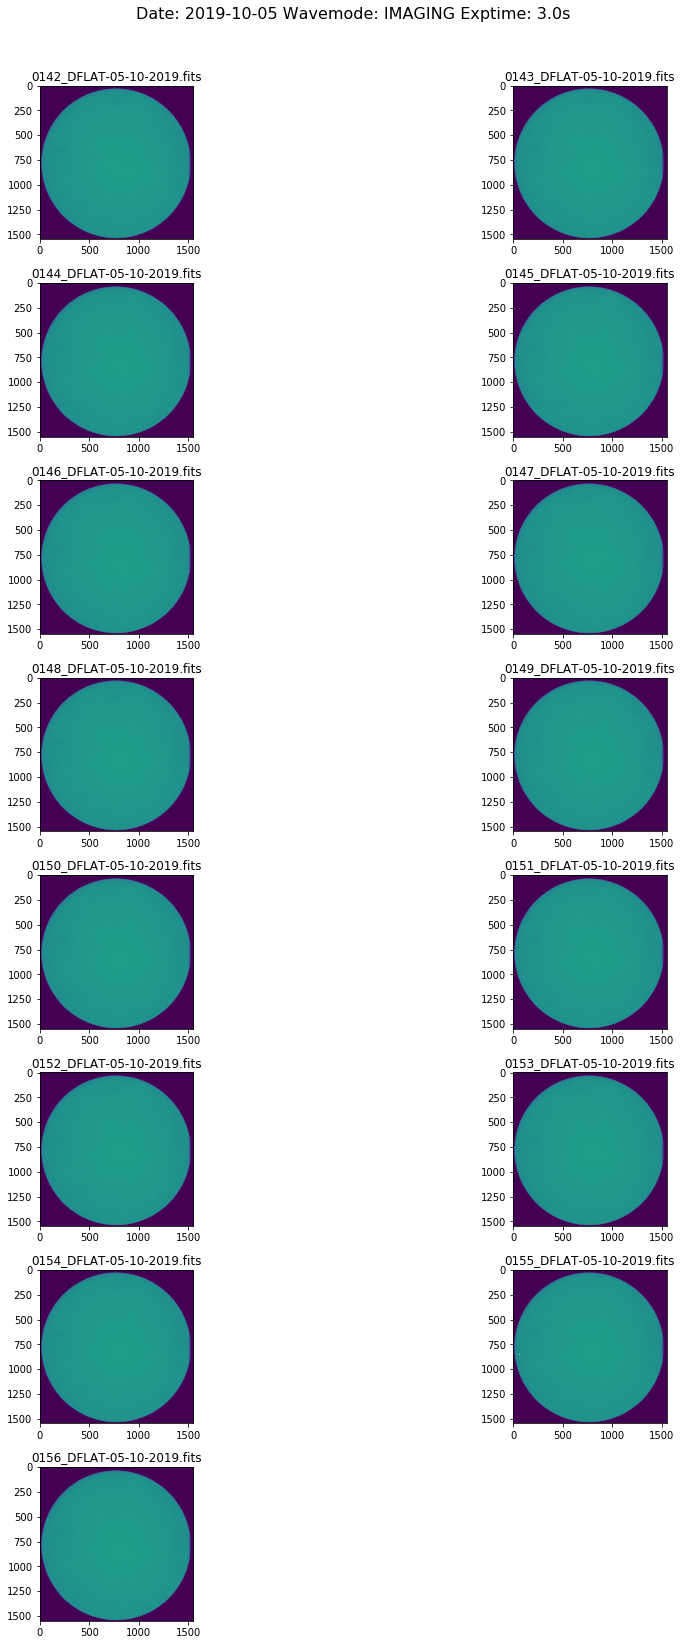

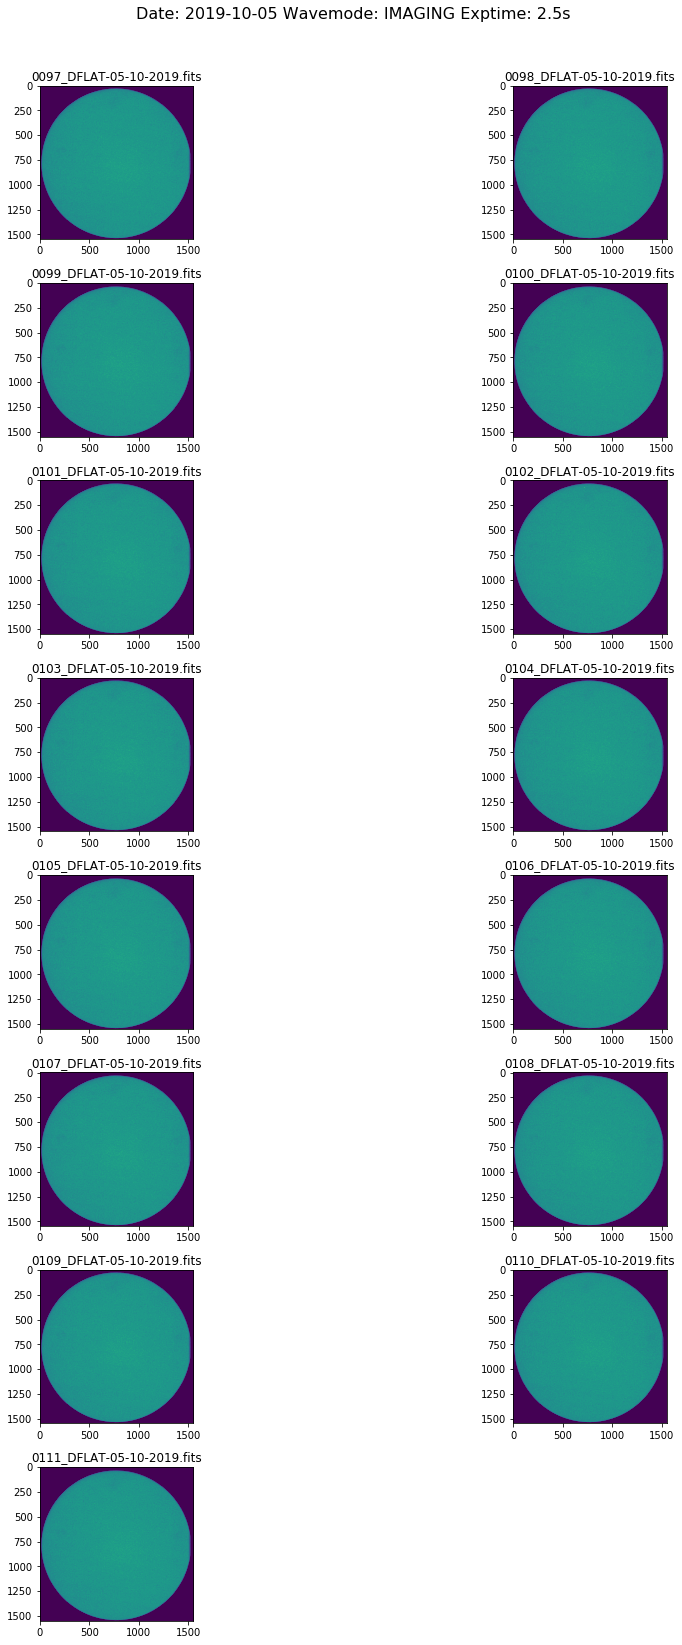

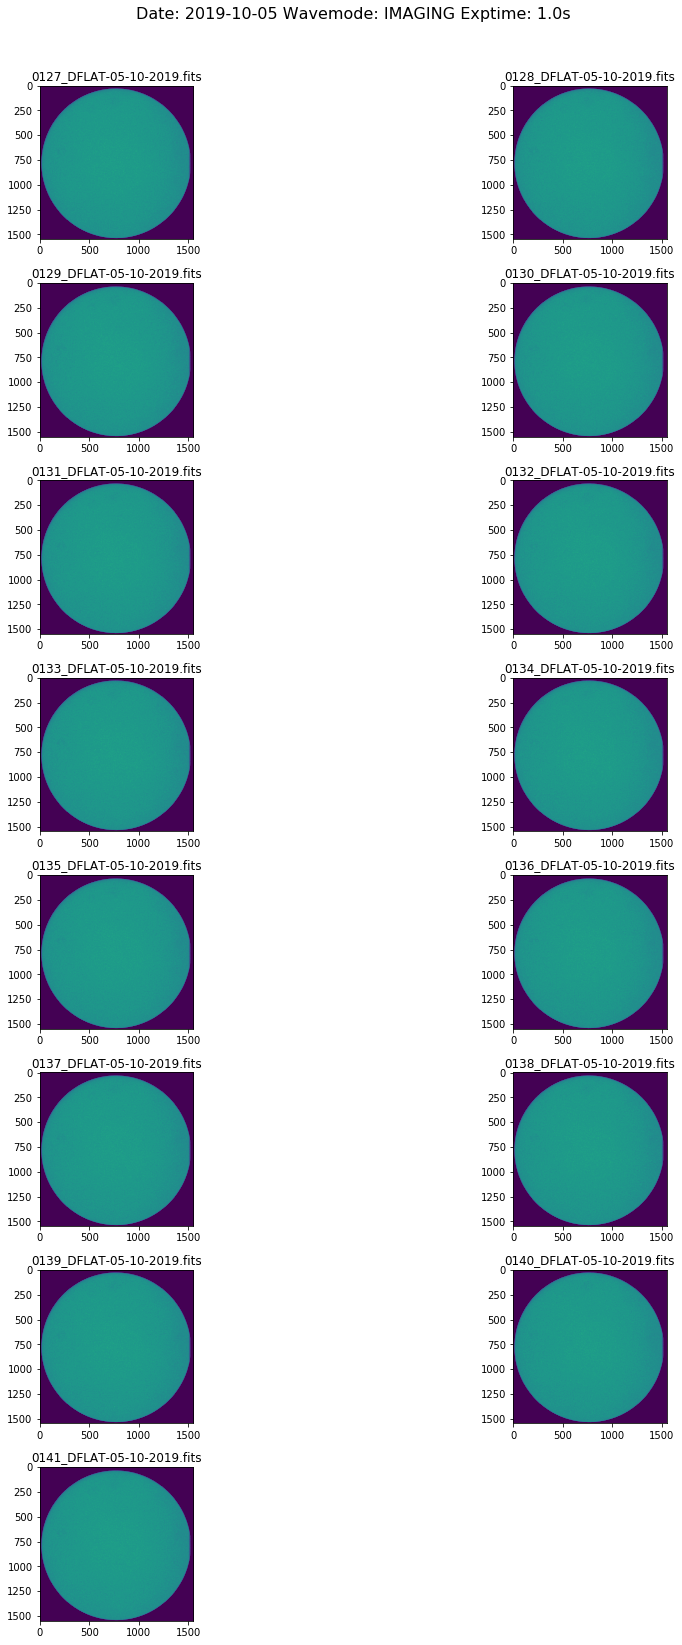

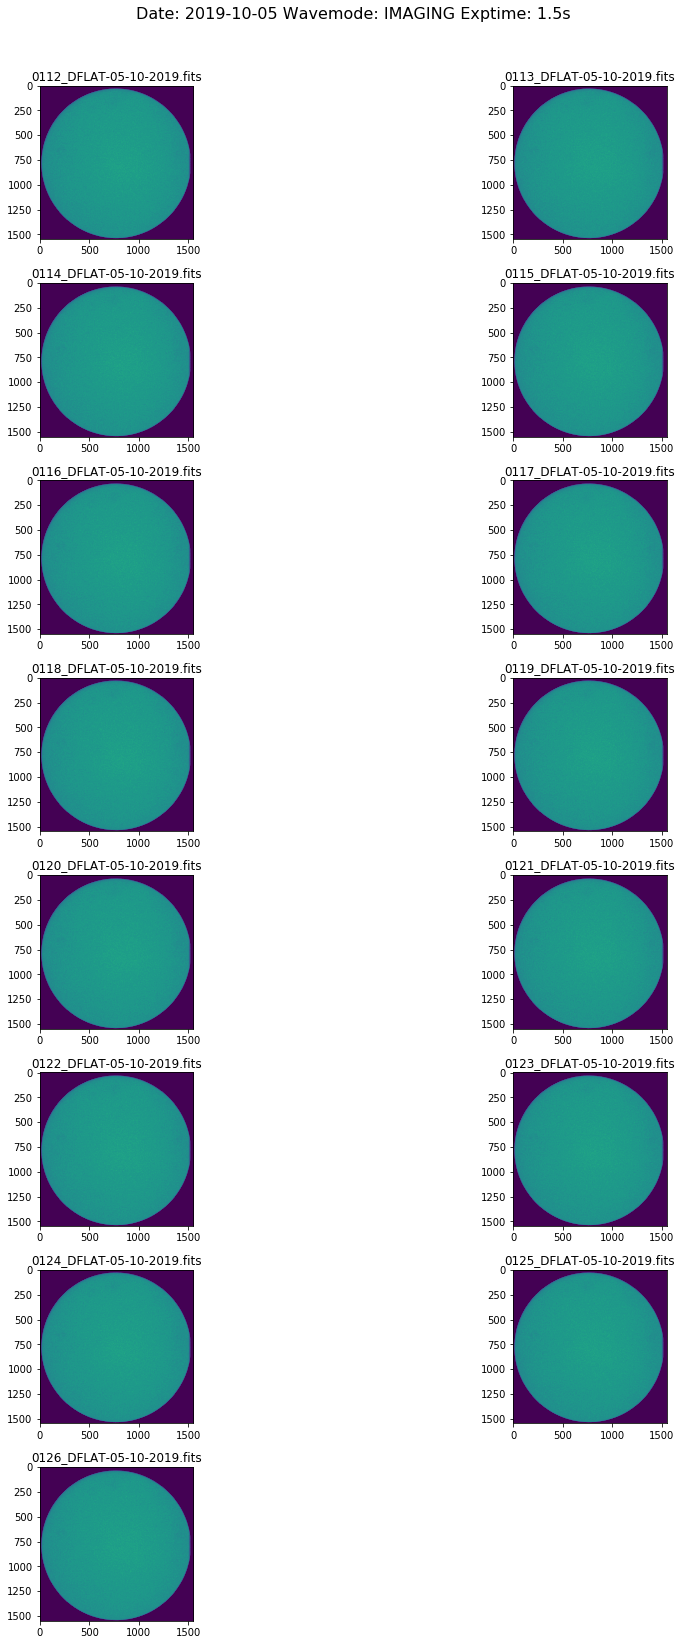

In [5]:
for group in groups:
    visualize_as_grid(group=group, date=date)

### Combine as MasterFlats

In [6]:
import re
def identify_technique(ccd):
    if 'Spectroscopic' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['ARC', 'SPECTRUM', 'COMP'] or \
            ccd.header['SLIT'] not in ['NO_MASK', '<NO MASK>'] or \
            ccd.header['GRATING'] not in ['NO_GRATING', '<NO GRATING>'] or \
            '_SP_' in ccd.header['OBJECT']:
        technique = 'Spectroscopy'
    elif 'Imaging' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['EXPOSE'] or\
            ccd.header['WAVMODE'] == 'IMAGING' or '_IM_' in ccd.header['OBJECT']:
        technique = 'Imaging'
    else:
        technique = 'Unknown'
    return technique


In [7]:
# !pip install goodman_pipeline==1.3.0rc3

In [8]:
import goodman_pipeline
import glob

print(goodman_pipeline.__version__)

from goodman_pipeline.core import create_master_flats, get_overscan_region, define_trim_section, get_slit_trim_section

1.3.0rc3


In [9]:
def combine_flats(group):
    new_data = []
    file_list = group.file.tolist()
    sample_file = os.path.join(data_location, date, file_list[0])
    sample_ccd = CCDData.read(sample_file, unit='adu')
    technique = identify_technique(ccd=sample_ccd)
    
    
    
    overscan_region = get_overscan_region(sample_image=sample_file, technique=technique)
    trim_section = define_trim_section(sample_image=sample_file, technique=technique)
    if technique == 'Spectroscopy':
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER2']))
        print(new_master_flat_name)
        master_bias_name = "master_bias_{}_SP_{}x{}_R{:05.2f}_G{:05.2f}.fits".format(sample_ccd.header['INSTCONF'].upper(),
                                                                                     sample_ccd.header['CCDSUM'].split()[0],
                                                                                     sample_ccd.header['CCDSUM'].split()[1],
                                                                                     sample_ccd.header['RDNOISE'],
                                                                                     sample_ccd.header['GAIN'])
        master_bias_file = os.path.join(data_location, date, 'master_bias', master_bias_name)
        print(master_bias_file)
    else:
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER']))
        print(new_master_flat_name)
        master_bias_name = "master_bias_{}_IM_{}x{}_R{:05.2f}_G{:05.2f}.fits".format(sample_ccd.header['INSTCONF'].upper(),
                                                                                     sample_ccd.header['CCDSUM'].split()[0],
                                                                                     sample_ccd.header['CCDSUM'].split()[1],
                                                                                     sample_ccd.header['RDNOISE'],
                                                                                     sample_ccd.header['GAIN'])
        master_bias_file = os.path.join(data_location, date, 'master_bias', master_bias_name)
        print(master_bias_file)
        
    if not os.path.isfile(master_bias_file):
        print("Master Bias {} does not exists".format(master_bias_file))
        master_bias_file = ''
        ignore_bias = True
        print("Ignoring bias!")
    else:
        print("Found master bias: {}".format(master_bias_file))
        ignore_bias = False
    
    master_flat, master_flat_name = create_master_flats(
        flat_files=file_list, 
        raw_data=os.path.join(data_location, date), 
        reduced_data=os.path.join(full_path_data_location, 'master_flats'), 
        technique=technique, 
        overscan_region=overscan_region, 
        trim_section=trim_section, 
        master_bias_name=master_bias_file, 
        new_master_flat_name=new_master_flat_name, 
        saturation_threshold=1, 
        ignore_bias=ignore_bias,)
    if technique == 'Spectroscopy':
        trim_section = get_slit_trim_section(master_flat=master_flat)
        
        master_flat = goodman_pipeline.core.image_trim(ccd=master_flat, trim_section=trim_section, trim_type='slit')
        master_flat.write(master_flat_name, overwrite=True)
        divider = 2.
    else:
        divider = 1.
    
    fig, ax = plt.subplots(figsize=(16, int(16/divider)))
    ax.title.set_text(os.path.basename(master_flat_name))
    z1 = np.mean(master_flat.data) - 0.5 * np.std(master_flat.data)
    z2 = np.median(master_flat.data) + np.std(master_flat.data)
    ax.imshow(master_flat.data, clim=(z1, z2), cmap='viridis')
    plt.show()
    print(master_flat_name)
    return technique, master_flat

master_flat_400_M1_NO_FILTER.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits


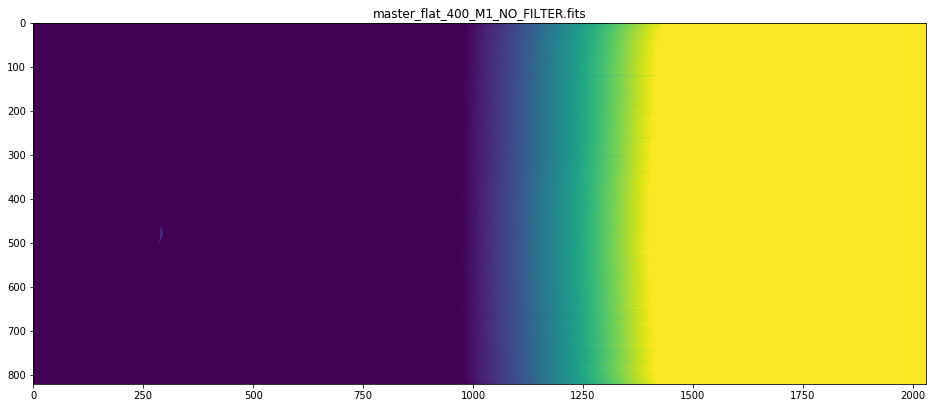

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_400_M1_NO_FILTER.fits
master_flat_400_M2_GG455.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits


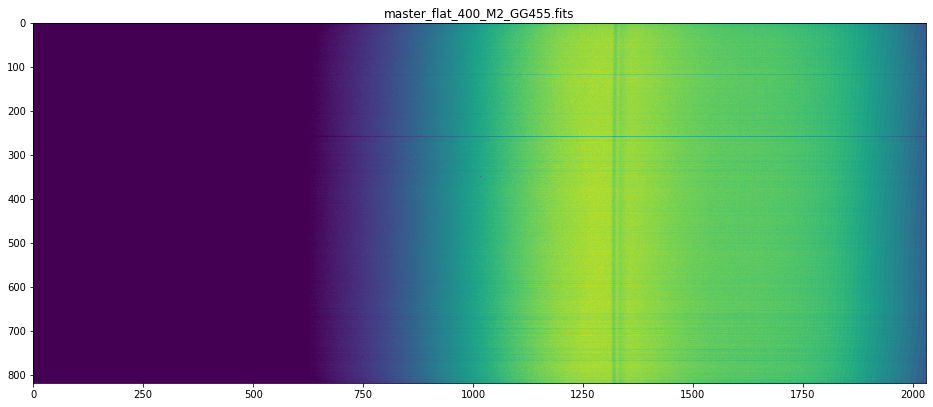

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_400_M2_GG455.fits
master_flat_IMAGING_VR.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


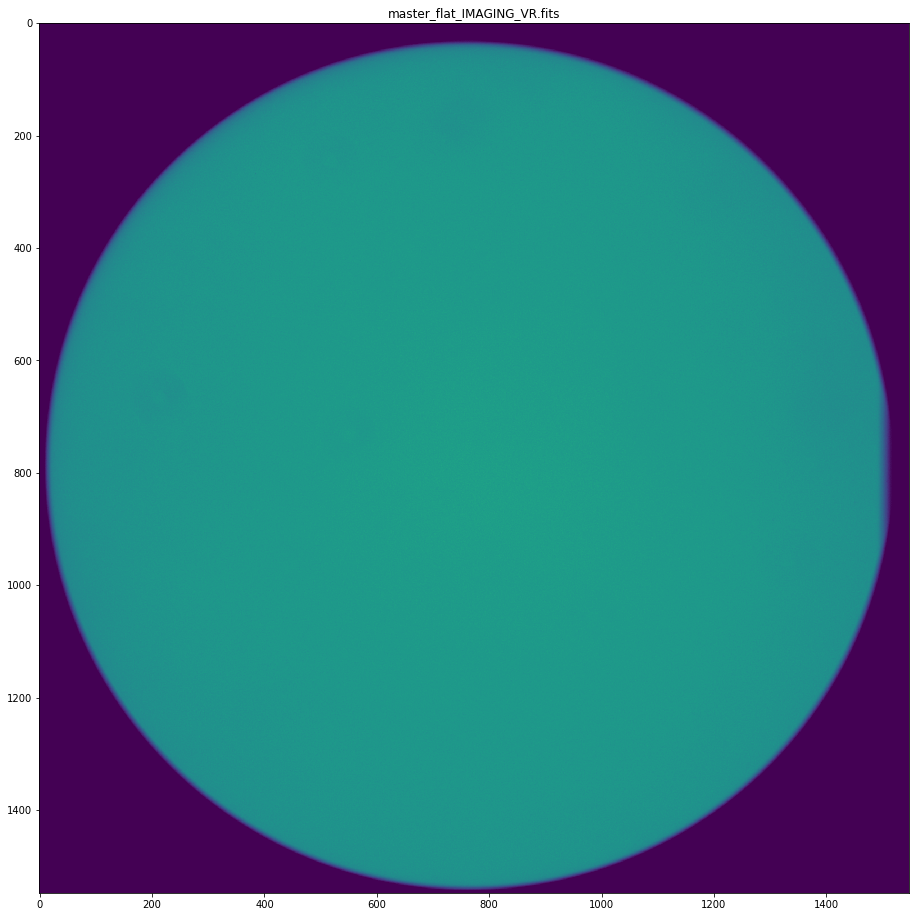

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_IMAGING_VR.fits
master_flat_IMAGING_g-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


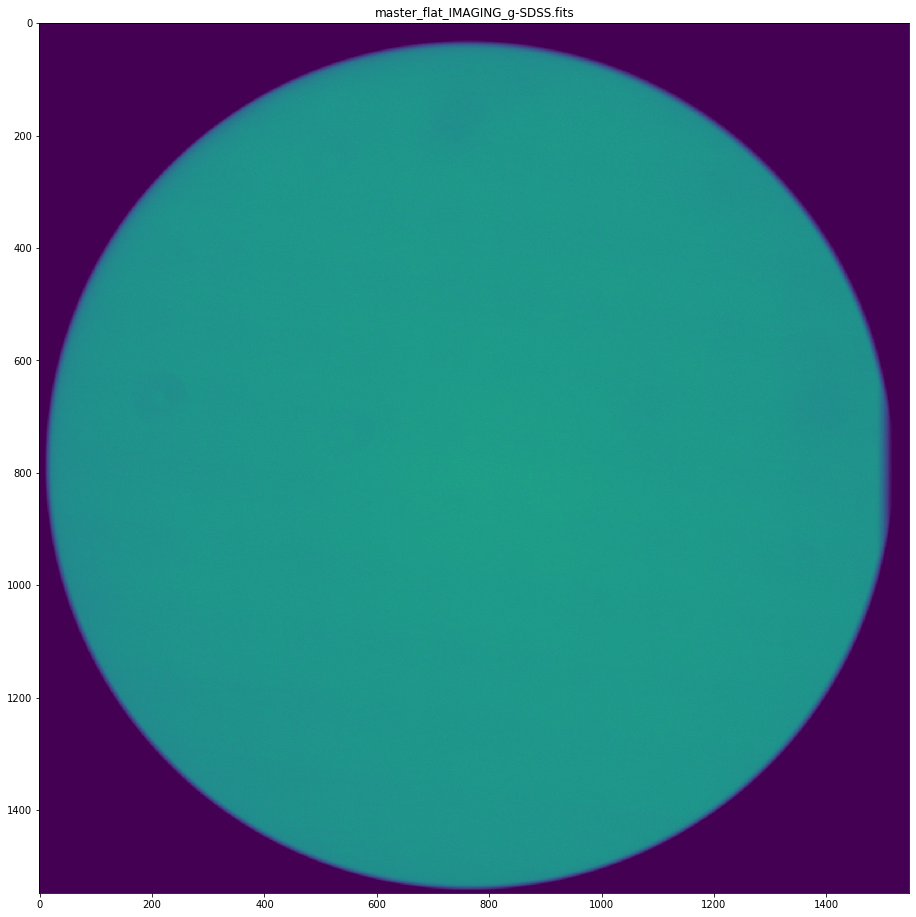

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_IMAGING_g-SDSS.fits
master_flat_IMAGING_i-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


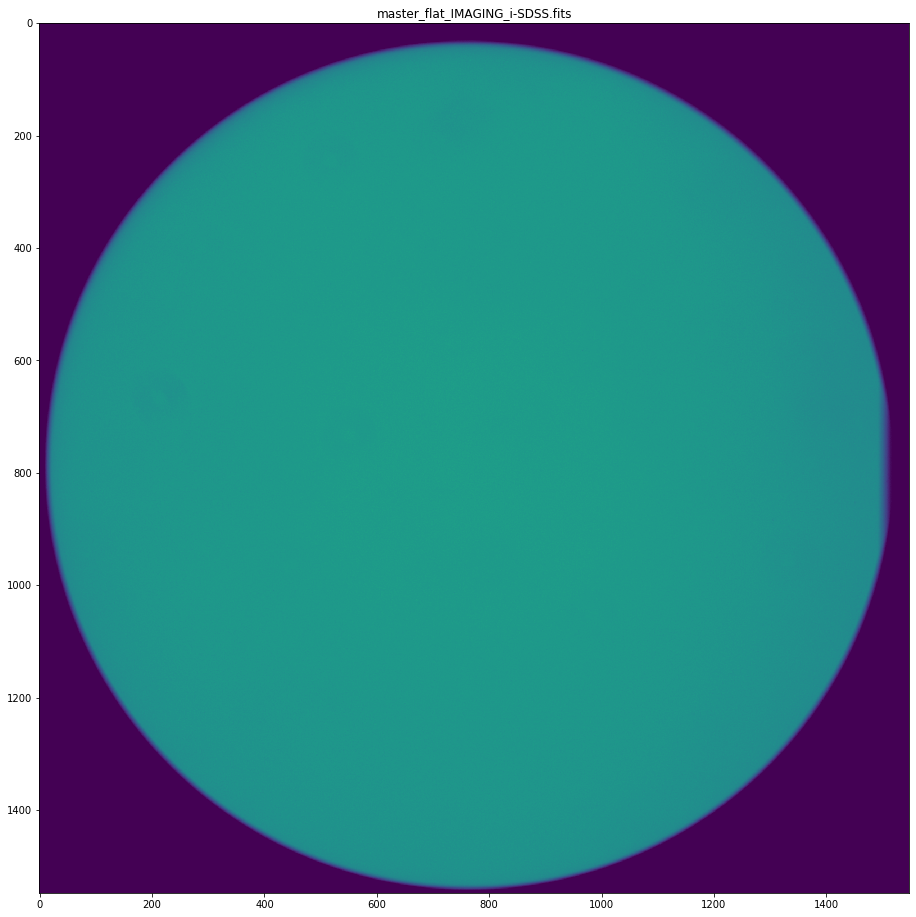

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_IMAGING_i-SDSS.fits
master_flat_IMAGING_r-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


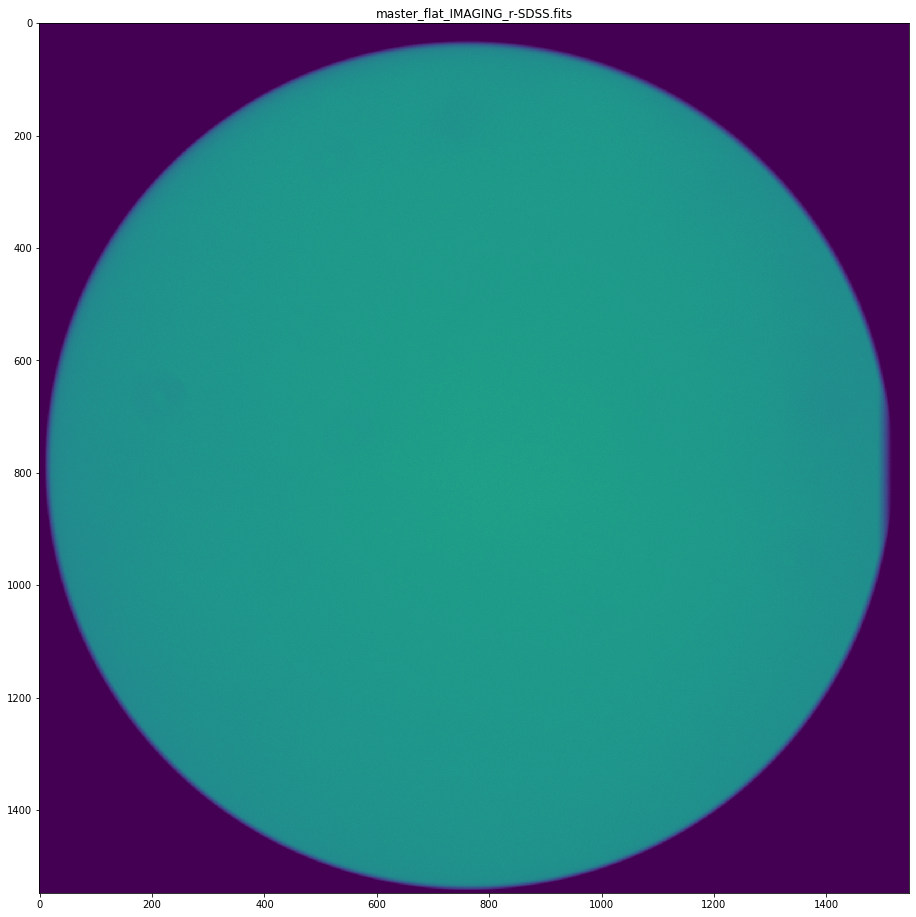

/user/simon/data/soar/flat_analisis_2019B/2019-10-05/master_flats/master_flat_IMAGING_r-SDSS.fits


In [10]:
all_data = []
for group in groups:
    technique, master_flat = combine_flats(group=group)
    all_data.append([group, technique, master_flat])

### Statistics


In [11]:
import logging

logger = logging.getLogger(__name__)
logger.propagate = False

In [12]:
%matplotlib inline

Spectroscopy Group Filter2: NO_FILTER Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M1
Spectroscopy Group Filter2: GG455 Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M2
Imaging Group Filter: VR
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)


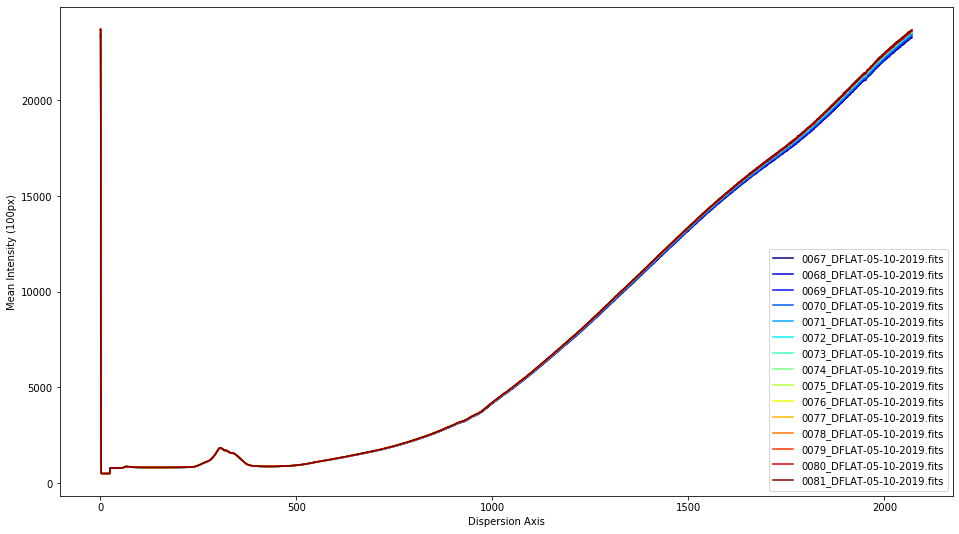

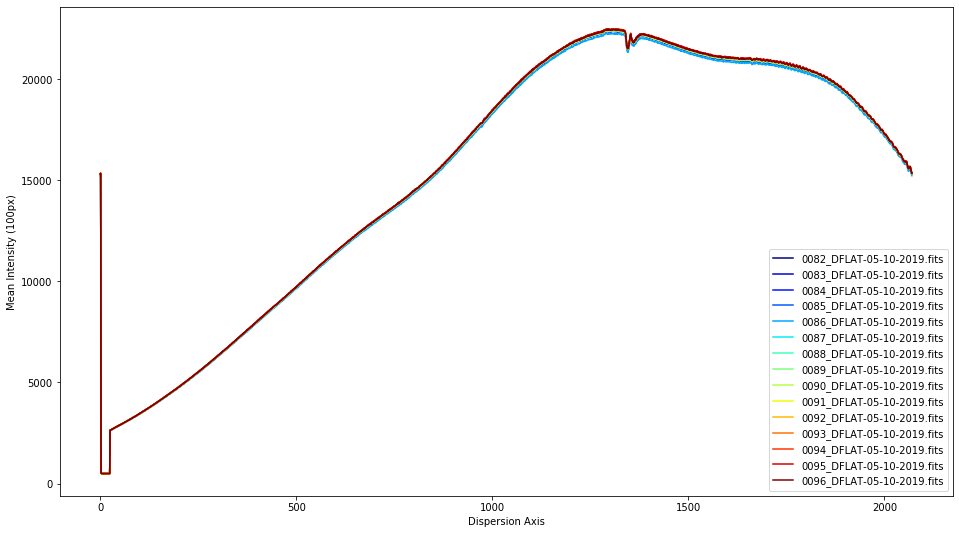

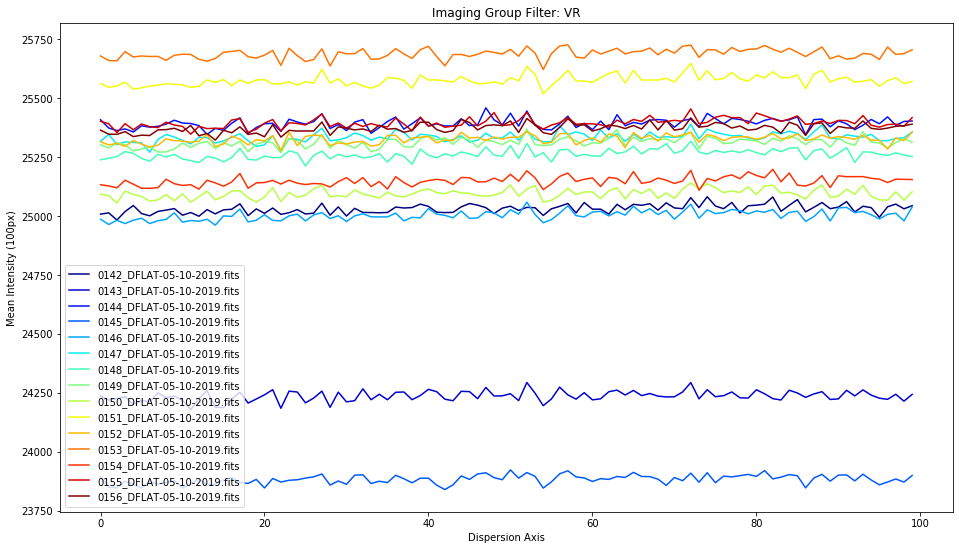

                          file   npix        mean      stddev    min    max
0   0142_DFLAT-05-10-2019.fits  10000  25030.4626  196.015177  21214  25790
1   0143_DFLAT-05-10-2019.fits  10000  24235.6401  190.113583  20467  25052
2   0144_DFLAT-05-10-2019.fits  10000  25392.8184  199.776221  21355  26204
3   0145_DFLAT-05-10-2019.fits  10000  23882.0684  189.137988  20111  24665
4   0146_DFLAT-05-10-2019.fits  10000  25002.8550  196.130101  20943  25690
5   0147_DFLAT-05-10-2019.fits  10000  25334.3417  198.795054  21536  26020
6   0148_DFLAT-05-10-2019.fits  10000  25261.8574  197.739847  21450  26071
7   0149_DFLAT-05-10-2019.fits  10000  25311.6844  194.326344  21467  26026
8   0150_DFLAT-05-10-2019.fits  10000  25094.7759  197.697413  21155  25849
9   0151_DFLAT-05-10-2019.fits  10000  25575.1922  201.916476  21727  26320
10  0152_DFLAT-05-10-2019.fits  10000  25325.5305  196.704615  21426  26000
11  0153_DFLAT-05-10-2019.fits  10000  25688.0480  199.848686  21622  26509
12  0154_DFL

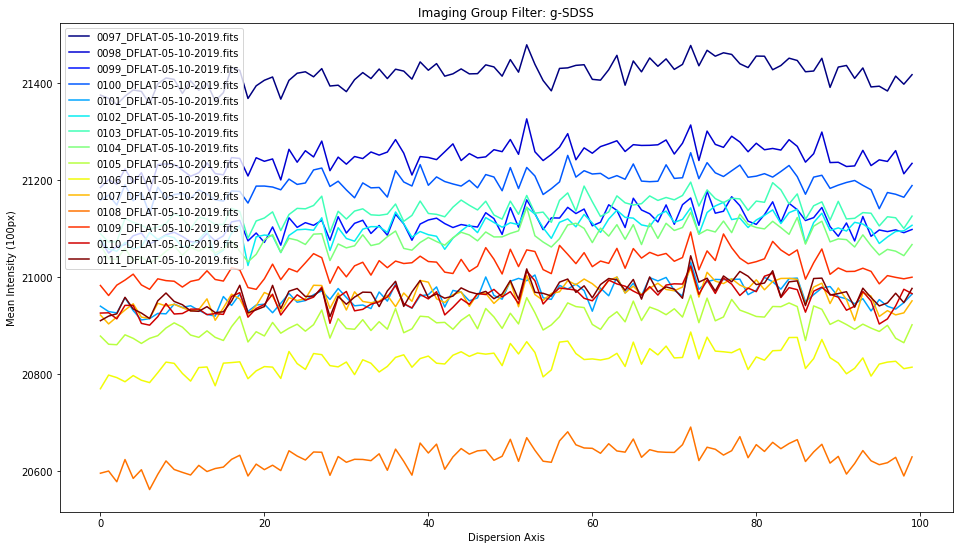

                          file   npix        mean      stddev    min    max
0   0097_DFLAT-05-10-2019.fits  10000  21418.2053  198.375889  17937  22196
1   0098_DFLAT-05-10-2019.fits  10000  21249.6635  196.790177  17668  21937
2   0099_DFLAT-05-10-2019.fits  10000  21110.0831  196.478621  17609  21794
3   0100_DFLAT-05-10-2019.fits  10000  21193.6653  199.449535  17747  21979
4   0101_DFLAT-05-10-2019.fits  10000  20961.6666  194.458673  17495  21655
5   0102_DFLAT-05-10-2019.fits  10000  21099.2282  198.693070  17530  21938
6   0103_DFLAT-05-10-2019.fits  10000  21136.1929  196.657606  17506  21827
7   0104_DFLAT-05-10-2019.fits  10000  21077.9237  195.797676  17677  21968
8   0105_DFLAT-05-10-2019.fits  10000  20906.6939  195.006514  17505  21673
9   0106_DFLAT-05-10-2019.fits  10000  20826.9396  194.895060  17633  21601
10  0107_DFLAT-05-10-2019.fits  10000  20960.8183  195.675981  17451  21844
11  0108_DFLAT-05-10-2019.fits  10000  20628.6091  194.663949  17218  21392
12  0109_DFL

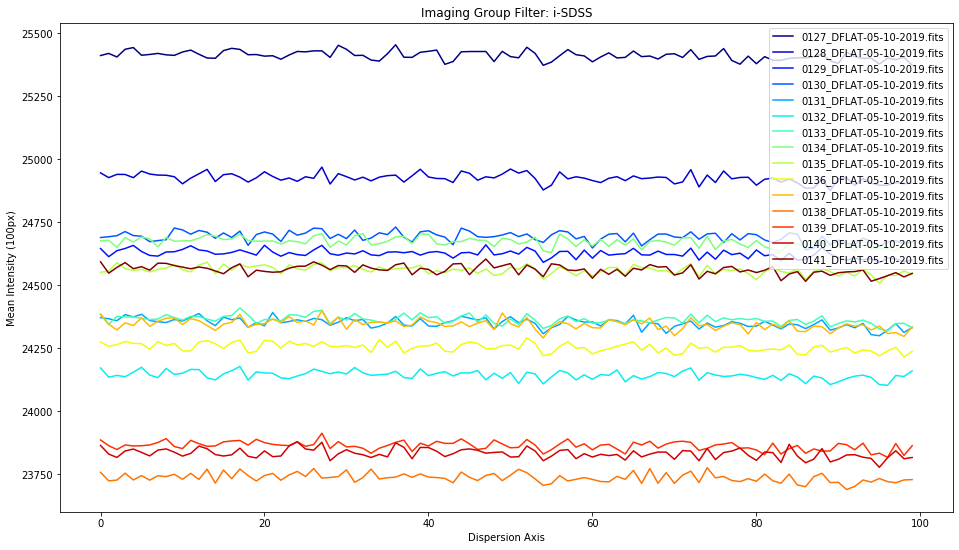

                          file   npix        mean      stddev    min    max
0   0127_DFLAT-05-10-2019.fits  10000  25409.9997  170.737981  21508  26072
1   0128_DFLAT-05-10-2019.fits  10000  24923.6157  166.052554  20980  25568
2   0129_DFLAT-05-10-2019.fits  10000  24624.3258  166.287923  20918  25430
3   0130_DFLAT-05-10-2019.fits  10000  24691.6279  167.234070  20762  25345
4   0131_DFLAT-05-10-2019.fits  10000  24350.1075  164.206279  20227  24901
5   0132_DFLAT-05-10-2019.fits  10000  24143.1416  163.615733  20087  24761
6   0133_DFLAT-05-10-2019.fits  10000  24363.1829  165.292368  20623  24898
7   0134_DFLAT-05-10-2019.fits  10000  24670.4015  166.989077  20586  25340
8   0135_DFLAT-05-10-2019.fits  10000  24559.2265  166.048622  20592  25123
9   0136_DFLAT-05-10-2019.fits  10000  24253.6152  164.333578  20451  24889
10  0137_DFLAT-05-10-2019.fits  10000  24344.1251  165.679531  20496  25070
11  0138_DFLAT-05-10-2019.fits  10000  23736.8968  162.449668  19816  24329
12  0139_DFL

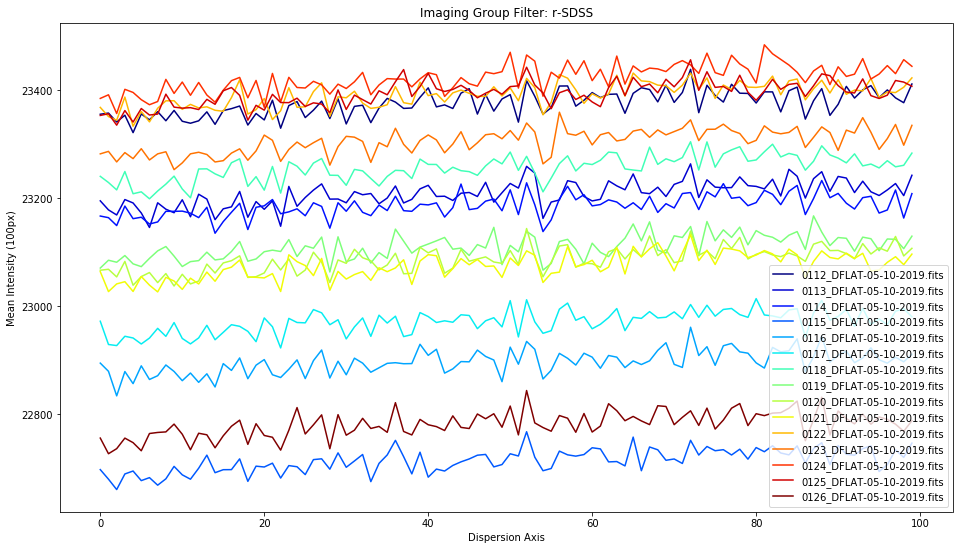

                          file   npix        mean      stddev    min    max
0   0112_DFLAT-05-10-2019.fits  10000  23375.5758  186.389291  19789  24049
1   0113_DFLAT-05-10-2019.fits  10000  23208.2661  186.307616  19679  23985
2   0114_DFLAT-05-10-2019.fits  10000  23185.8661  188.382072  19556  23919
3   0115_DFLAT-05-10-2019.fits  10000  22713.4395  181.338591  19213  23365
4   0116_DFLAT-05-10-2019.fits  10000  22896.1829  184.323273  19242  23623
5   0117_DFLAT-05-10-2019.fits  10000  22970.8354  186.606527  19398  23713
6   0118_DFLAT-05-10-2019.fits  10000  23256.3717  186.417375  19866  24058
7   0119_DFLAT-05-10-2019.fits  10000  23109.9119  187.752536  19519  23786
8   0120_DFLAT-05-10-2019.fits  10000  23085.9936  185.540005  19347  23755
9   0121_DFLAT-05-10-2019.fits  10000  23074.2430  185.781581  19492  23764
10  0122_DFLAT-05-10-2019.fits  10000  23391.2080  189.435107  19558  24080
11  0123_DFLAT-05-10-2019.fits  10000  23305.2834  187.650302  19553  23954
12  0124_DFL

In [13]:
import pandas as pd
for group, technique, master_flat in all_data:
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, len(group))]
    if technique == 'Spectroscopy':
        print('Spectroscopy Group Filter2: {} Grating: {} Slit: {} Wavmode: {}'.format(group.filter2.unique()[0],
                                                                                       group.grating.unique()[0], 
                                                                                       group.slit.unique()[0], 
                                                                                       group.wavmode.unique()[0]))
              
        fig_1, ax_1 = plt.subplots(figsize=(16,9))
#         fig_1, ax_1 = plt.subplots()
        ax_1.set_xlabel('Dispersion Axis')
        ax_1.set_ylabel('Mean Intensity (100px)')
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 49
            
            y_0 = 1
            y_1 = y
            
            region = "[:, {}:{}]".format(x_0, x_1)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
            ccd.data = np.mean(ccd.data, axis=0)
            ax_1.plot(ccd.data, color=colors[i], label=_image)
        plt.legend(loc='best')
#         plt.show()
    else:
        _title = 'Imaging Group Filter: {}'.format(group['filter'].unique()[0])
        print(_title)
        _data = {'file': [], 'npix': [], 'mean': [], 'stddev': [], 'min': [], 'max': []}
        
        fig, ax = plt.subplots(figsize=(16,9))
#         fig, ax = plt.subplots()
        ax.set_xlabel('Dispersion Axis')
        ax.set_ylabel('Mean Intensity (100px)')
        ax.set_title(_title)
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 49
            
            y_0 = int(y / 2.) - 50
            y_1 = int(y / 2.) + 49
            
            region = "[{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1)
            print(region)
            print(ccd.data.shape)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
            print(ccd.data.shape)
#             fig, ax = plt.subplots(figsize=(16, 9))
#             ax.imshow(ccd.data, cmap='viridis')
            # IMAGE      NPIX      MEAN    STDDEV       MIN       MAX
            _npix = np.prod(ccd.data.shape)
            _mean = np.mean(ccd.data)
            _stdev = np.std(ccd.data)
            _min = np.min(ccd.data)
            _max = np.max(ccd.data)
            _data['file'].append(_image)
            _data['npix'].append(_npix)
            _data['mean'].append(_mean)
            _data['stddev'].append(_stdev)
            _data['min'].append(_min)
            _data['max'].append(_max)
            
            
            mean_data = np.mean(ccd.data, axis=0)
            ax.plot(mean_data, color=colors[i], label=_image)
        plt.legend(loc='best')
        plt.show()
            
        df = pd.DataFrame(data=_data)
        print(df.to_string())
        print(" ")
            
            

#             print("extraction zone [{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1))
             